## Init notebook

This is run once.

## Preliminaries

In [1]:
import quantus

/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-13 13:35:54.428398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 13:35:55.163637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum
import torchvision
import matplotlib.cm as cm
import gc

from zennit import attribution as zattr
from zennit import image as zimage
from zennit import composites as zcomp

from models import models
from data import dataloaders, datasets, transforms
from attribution import zennit_utils as zutils
from utils import arguments as argument_utils
from main import *

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

/home/lweber/work-code/Quantus/quantus/__init__.py
Using device: NVIDIA TITAN RTX


In [3]:
# Plot Parameters
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})

In [4]:
def smoothexplain(model, inputs, targets, **kwargs):

    xai_noiselevel = kwargs.pop("xai_noiselevel", 0.1)
    xai_n_noisedraws = kwargs.pop("xai_n_noisedraws", 1)
    
    device = kwargs.get("device", None)
    if not isinstance(inputs, torch.Tensor):
        inputs = torch.Tensor(inputs).to(device)

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).to(device)

    dims = tuple(range(1, inputs.ndim))
    std = xai_noiselevel * (inputs.amax(dims, keepdim=True) - inputs.amin(dims, keepdim=True))

    result = np.zeros(inputs.shape)
    for n in range(xai_n_noisedraws):
        # the last epsilon is defined as zero to compute the true output,
        # and have SmoothGrad w/ n_iter = 1 === gradient
        if n == xai_n_noisedraws - 1:
            epsilon = torch.zeros_like(inputs)
        else:
            epsilon = torch.randn_like(inputs) * std
            
        expl = quantus.explain(model, inputs + epsilon, targets, **kwargs)
        result += expl / xai_n_noisedraws

    return result

## Experiment



Preparing datasets...
DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/Datasets/imagenet/val
Number of Samples in Dataset: 1000
Reduced of Samples in Dataset: 50
Preparing dataloaders...


/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_596785/2987615394.py:47: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fix, ax = plt.subplots(1, 5, figsize=(12, 4))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data

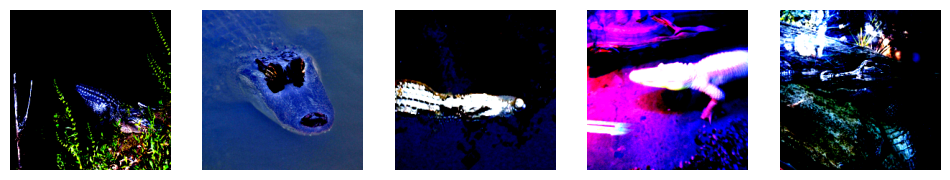

In [5]:
# Load data.
dataset_name = "imagenet"
model_name = "vgg16"
nr_test_samples = 50
num_classes = 1000
data_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/Datasets/imagenet"
labelmap_path = "label_map_imagenet.json"

# Get Dataset
# Prepare transforms
transform = transforms.get_transforms(dataset_name, mode="test")

# Prepare datasets
print("Preparing datasets...")
dataset = datasets.get_dataset(
    dataset_name,
    data_path,
    transform,
    mode="test",
    labelmap_path=labelmap_path
)

print(f"Number of Samples in Dataset: {len(dataset.samples)}")
dataset.samples = dataset.samples[:nr_test_samples]
print(f"Reduced of Samples in Dataset: {len(dataset.samples)}")

# Prepare dataloaders
print("Preparing dataloaders...")
loader = dataloaders.get_dataloader(
    dataset_name = dataset_name,
    dataset = dataset,
    batch_size = 32,
    shuffle = True,
)
# Prepare model
model = models.get_model(model_name, device)
model.eval()

for i, (batch, labels) in enumerate(loader):

    x_batch = batch.numpy()

    img_size = x_batch.shape[2]
    nr_channels = x_batch.shape[1]

    # Plot the data!
    fix, ax = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(img_size, img_size, nr_channels))
        ax[i].axis("off")
    plt.show()

    break

In [6]:
quantus.AVAILABLE_XAI_METHODS_CAPTUM

['GradientShap',
 'IntegratedGradients',
 'DeepLift',
 'DeepLiftShap',
 'InputXGradient',
 'Saliency',
 'FeatureAblation',
 'Deconvolution',
 'FeaturePermutation',
 'Lime',
 'KernelShap',
 'LRP',
 'Gradient',
 'Occlusion',
 'LayerGradCam',
 'GuidedGradCam',
 'LayerConductance',
 'LayerActivation',
 'InternalInfluence',
 'LayerGradientXActivation',
 'Control Var. Sobel Filter',
 'Control Var. Constant',
 'Control Var. Random Uniform']

In [7]:
XAI_METHOD_KWARGS = {
    r"LRP-$z^+$": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "composite": zutils.ZPlus,
        "canonizer": zutils.get_zennit_canonizer(model),
        "canonizer_kwargs": {},
        "composite_kwargs": {
            "stabilizer": 1e-6,
        },
        "device": device,
    },
    "Gradient": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "canonizer": None,
        "composite": None,
        "canonizer_kwargs": {},
        "composite_kwargs": {},
        "device": device,
    },
    # "SmoothGrad": {
    #     "xai_lib": "zennit",
    #     "attributor": zattr.SmoothGrad,
    #     "attributor_kwargs": {
    #         "n_iter": 20,
    #         "noise_level": 0.1
    #     },
    #     "canonizer": None,
    #     "composite": None,
    #     "canonizer_kwargs": {},
    #     "composite_kwargs": {},
    #     "device": device,
    # },
    # "IntegratedGradients": {
    #     "xai_lib": "zennit",
    #     "attributor": zattr.IntegratedGradients,
    #     "attributor_kwargs": {
    #         "n_iter": 20,
    #     },
    #     "canonizer": None,
    #     "composite": None,
    #     "canonizer_kwargs": {},
    #     "composite_kwargs": {},
    #     "device": device,
    # },
    r"LRP-$\varepsilon$": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "composite": zutils.Epsilon,
        "canonizer": zutils.get_zennit_canonizer(model),
        "canonizer_kwargs": {},
        "composite_kwargs": {
            "stabilizer": 1e-6,
            "epsilon": 1e-6
        },
        "device": device,
    },
    "GuidedBackprop": {
        "xai_lib": "zennit",
        "attributor": zattr.Gradient,
        "canonizer": None,
        "composite": zcomp.GuidedBackprop,
        "canonizer_kwargs": {},
        "composite_kwargs": {},
        "device": device,
    },
    # "GradCAM" : {
    #     "xai_lib": "captum",
    #     "device": device,
    #     "gc_layer": eval("model.features[-2]") if model_name == "vgg16" else eval("list(model.named_modules())[61][1]"),
    #     "interpolate": (img_size, img_size),
    #     "interpolate_mode": "bilinear",
    #     "method": "LayerGradCam",
    # }
}

In [8]:
# Load explanation methods.
#xai_setting = ["GradCAM",] #KernelShap, Lime
xai_setting = list(XAI_METHOD_KWARGS.keys())
              
xai_methods = {
    xai_methodname: XAI_METHOD_KWARGS[xai_methodname] for xai_methodname in xai_setting
}

xai_methods

{'LRP-$z^+$': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'composite': attribution.zennit_utils.ZPlus,
  'canonizer': zennit.torchvision.VGGCanonizer,
  'canonizer_kwargs': {},
  'composite_kwargs': {'stabilizer': 1e-06},
  'device': device(type='cuda', index=0)},
 'Gradient': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'canonizer': None,
  'composite': None,
  'canonizer_kwargs': {},
  'composite_kwargs': {},
  'device': device(type='cuda', index=0)},
 'LRP-$\\varepsilon$': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'composite': attribution.zennit_utils.Epsilon,
  'canonizer': zennit.torchvision.VGGCanonizer,
  'canonizer_kwargs': {},
  'composite_kwargs': {'stabilizer': 1e-06, 'epsilon': 1e-06},
  'device': device(type='cuda', index=0)},
 'GuidedBackprop': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'canonizer': None,
  'composite': zennit.composites.GuidedBackprop,
  'canonizer_kwarg

In [9]:

n_bins = 100 #int(np.sqrt(len(x_batch[0].flatten())))
xai_n_noisedraw_list = [1, 10, 50, 100]

from quantus.functions.normalise_func import normalise_and_shift_by_minmax

scores = {}

for xai_method, xai_method_kwargs in xai_methods.items():

    metric = quantus.eMPRT(
            layer_order="bottom_up",
            return_average_sample_score=False,
            complexity_func=quantus.complexity_func.discrete_entropy,
            complexity_func_kwargs={"n_bins": n_bins}, #scotts
            compute_delta=True,
            compute_correlation=False,
            similarity_func=quantus.correlation_spearman,
            skip_layers=False,
            abs=True if xai_method in ["Gradient", "GradCAM"] else False,
            normalise=False,
            disable_warnings=True,
        )

    scores[xai_method] = {}

    for xai_n_noisedraws in xai_n_noisedraw_list:
        scores[xai_method][xai_n_noisedraws] = {}
        scores[xai_method][xai_n_noisedraws]["model_scores"] = []
        scores[xai_method][xai_n_noisedraws]["explanation_scores"] = []
        scores[xai_method][xai_n_noisedraws]["explanation_random_scores"] = []
        scores[xai_method][xai_n_noisedraws]["delta_explanation_scores"] = []
        scores[xai_method][xai_n_noisedraws]["delta_model_scores"] = []
        scores[xai_method][xai_n_noisedraws]["delta_model_scores"] = []

        print(f"Computing {xai_method} explanations with {xai_n_noisedraws} samples")

        for i, (batch, labels) in enumerate(loader):

            #print("Evaluating Batch {}/{}".format(i+1, len(loader)))

            batch_results = metric(
                model=model,
                x_batch=batch.numpy(),
                y_batch=labels.numpy(),
                a_batch=None,
                device=device,
                explain_func=smoothexplain,
                explain_func_kwargs={**xai_method_kwargs, "xai_n_noisedraws": xai_n_noisedraws}
            )

            # Results are returned/saved as a dictionary not like in the super-class as a list.
            #scores[xai_method][xai_n_noisedraws]["model_scores"] += metric.model_scores
            #scores[xai_method][xai_n_noisedraws]["explanation_scores"] += metric.explanation_scores
            #scores[xai_method][xai_n_noisedraws]["explanation_random_scores"] += metric.explanation_random_scores
            scores[xai_method][xai_n_noisedraws]["delta_explanation_scores"] += metric.delta_explanation_scores
            #scores[xai_method][xai_n_noisedraws]["delta_model_scores"] += metric.delta_model_scores
            #scores[xai_method][xai_n_noisedraws]["delta_model_scores"] += metric.correlation_scores

        torch.cuda.empty_cache()
        gc.collect()

print("Done Computing explanations")

Computing LRP-$z^+$ explanations with 1 samples


/home/lweber/work-code/Quantus/quantus/functions/explanation_func.py:117: UserWarning: Using quantus 'explain' function as an explainer without specifying 'method' (string) in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(


Computing LRP-$z^+$ explanations with 10 samples
Computing LRP-$z^+$ explanations with 50 samples


## Plot Shattering Sensitivity of eMPRT

{'Gradient': {1: {'model_scores': [], 'explanation_scores': [], 'explanation_random_scores': [], 'delta_explanation_scores': [1.183385610054041, 1.0636590867046758, 1.9067768542394954, 0.9942612538680762, 1.2339517217431242, 1.5405353675648104, 1.0627127518440833, 1.4251810250157084, 0.7600330883535347, 1.0079854362943137, 1.1384132850503774, 1.8892631824607218, 1.2942777631960358, 1.818655134871605, 0.9466655645909601, 1.794743966525703, 1.3927776617824081, 1.5112681244755666, 0.6109068433785492, 1.0489645759094257, 0.6681073861141833, 1.3583140083107859, 0.8628747091743802, 1.527224048919797, 0.9115933402057808, 1.2924051281554725, 0.9238338201444476, 1.0444274206576925, 1.6763831631403847, 1.2229860178377363, 0.6406562906179243, 1.2461696168790035, 0.6237341464733617, 0.930154732516439, 1.7259340190936432, 0.9599118024926501, 0.6622362199943916, 2.076665572995676, 1.397383388948795, 0.8664368784570593, 1.4614574409143355, 1.4866656380104009, 0.9970963031765692, 0.9693596328515461, 1

/tmp/ipykernel_132339/2023964898.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
/tmp/ipykernel_132339/2023964898.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab10")(np.linspace(0, 1, 10))


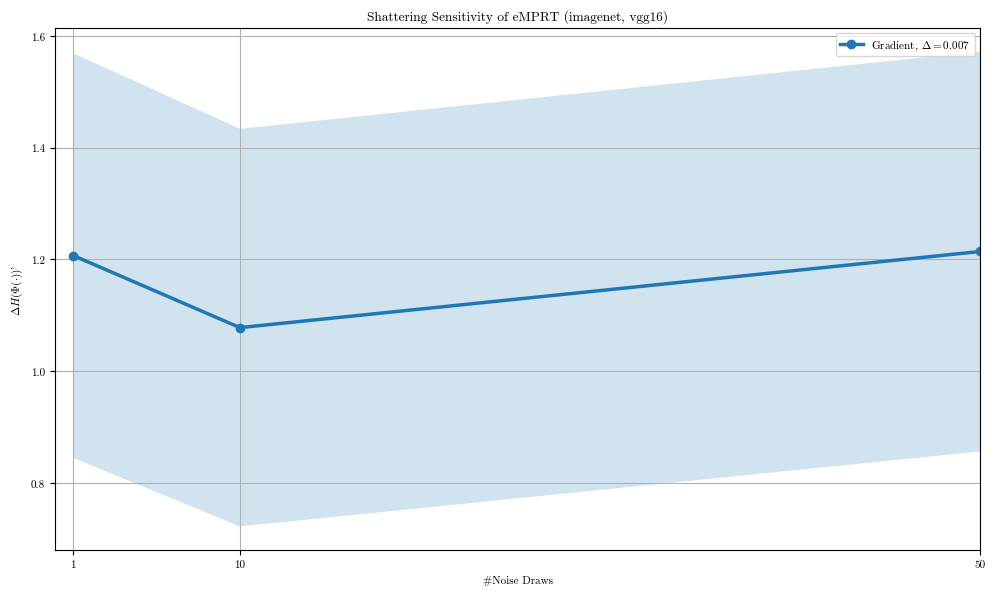

In [ ]:

print(scores)
# Plot Shattering Sensitivity of eMPRT
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title(f"Shattering Sensitivity of eMPRT ({dataset_name}, {model_name})")
mean_alpha = 1.0
std_alpha = 0.2

ax.set_ylabel("$\Delta H(\\Phi(\\cdot))$'")
#ax.set_ylim([0.0, 1.1])
#ax.set_yticks([0, 0.5, 1.0])
#ax.set_yticklabels([0, 0.5, 1])

ax.set_xlabel("#Noise Draws")
ax.set_xlim([0, xai_n_noisedraw_list[-1]])
ax.set_xticks(xai_n_noisedraw_list)
ax.set_xticklabels(xai_n_noisedraw_list)

palette = cm.get_cmap("tab10")(np.linspace(0, 1, 10))
linewidth = 2.5

for m, method in enumerate(scores.keys()):

    draw_numbers = []
    delta_means = []
    delta_stds = []

    for n_draws, data in scores[method].items():

        draw_numbers.append(n_draws)
        delta_means.append(np.mean(data["delta_explanation_scores"]))
        delta_stds.append(np.std(data["delta_explanation_scores"]))

    draw_numbers = np.array(draw_numbers)
    delta_means = np.array(delta_means)
    delta_stds = np.array(delta_stds)

    ax.plot(draw_numbers, delta_means, alpha=mean_alpha, linewidth=linewidth, marker="o", color=palette[m], label=r"{}, $\Delta=${:.3f}".format(method,delta_means[-1]-delta_means[0]))
    ax.fill_between(draw_numbers, delta_means+delta_stds, delta_means-delta_stds, facecolor=palette[m], alpha=std_alpha)

plt.grid(True)
plt.legend()
plt.tight_layout()